In [1]:
#!/usr/bin/env python3
from argparse import ArgumentParser
import numpy as np
import torch
from data import PermutedMNIST
from train import train
from model import MLP
import utils
import random
import matplotlib.pyplot as plt



batch_size = 128
fisher_estimation_sample_size = 2048
weight_decay = 0
cuda=True
torch.backends.cudnn.benchmark = True
torch.backends.cudnn.fastest = True



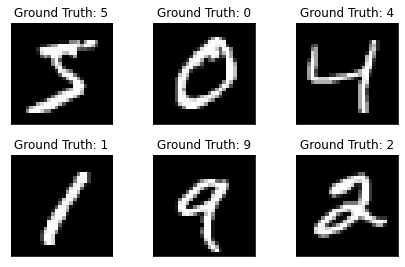

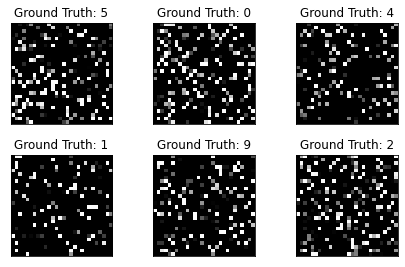

In [2]:
def imshow(img,labels):
    fig = plt.figure()
    for i in range(6):
        plt.subplot(2,3,i+1)
        plt.tight_layout()
        plt.imshow(img[i].view(28,28), cmap='gray', interpolation='none')
        plt.title("Ground Truth: {}".format(labels[i]))
        plt.xticks([])
        plt.yticks([])
            
            
def get_permute_mnist():
   
    train_loader = {}
    test_loader = {}
    idx = list(range(28 * 28))
    for i in range(task_number):
        train_loader[i] = torch.utils.data.DataLoader(PermutedMNIST(train = True, permute_idx=idx),
                                                      batch_size=batch_size,
                                                      num_workers=4)
        test_loader[i] = torch.utils.data.DataLoader(PermutedMNIST(train = False, permute_idx= idx),
                                                     batch_size=batch_size)
        random.shuffle(idx)
    return train_loader, test_loader


train_loader, test_loader = get_permute_mnist()

#unpermuted data:
examples_unpermuted = enumerate(train_loader[0])

_, (example_data_unpermuted, example_targets_unpermuted) = next(examples_unpermuted)

imshow(example_data_unpermuted[:6], example_targets_unpermuted[:6])

#permuted data:
examples_permuted = enumerate(train_loader[1])

_, (example_data_permuted, example_targets_permuted) = next(examples_permuted)
imshow(example_data_permuted[:6], example_targets_permuted[:6])

In [3]:
#could also cut last 5 items which are ignored by early stopping
def loss_plot(x):
    num_epochs = 0
    for task in range(1, task_number+1):
        plt.plot(range(num_epochs+1, num_epochs + 1 + len(x[task])), x[task] )
        num_epochs+= len(x[task])
        
def accuracy_plot(x):
    total_epochs = len(x[1])
    for task in range(1, task_number + 1):
        plt.plot(range(total_epochs+1 - len(x[task]), total_epochs+1), x[task] )



In [4]:
def avg_precision_plot(precisions, labels = []): #precisions needs to be in the form of the return value of train
    for num, precision in enumerate(precisions):    
        avg_precisions = []
        total_epochs = task_number*epochs_per_task
        for epoch in range (total_epochs):
            avg_precision = 0
            tasks_considered = epoch // epochs_per_task +1 #gives 1 for first task, 2 for second,...
            for i in range(1,tasks_considered+1): #
                avg_precision += precision[i][epoch - (i-1)*epochs_per_task]
            avg_precision/=tasks_considered
            avg_precisions.append(avg_precision)
        plt.ylim(0.88, 0.94)
        if (len(labels) == len(precisions)):
            plt.plot(range(total_epochs), avg_precisions, label = labels[num])
        else:
            plt.plot(range(total_epochs), avg_precisions)
    plt.legend()
    

In [5]:
#high learning rate, no dropout, no early stopping
hidden_size1=512
hidden_size2 = 256
lamda=400
lr=2.e-2
hidden_dropout_prob=0
input_dropout_prob=0
early_stopping = False
consolidate = False

In [6]:
# prepare the model.
mlp_no_dropout_no_earlystopping = MLP( 28*28, 10,
    hidden_size1,
    hidden_size2,
    hidden_dropout_prob,
    input_dropout_prob,
    lamda,
)

# initialize the weights.
utils.gaussian_initialize(mlp_no_dropout_no_earlystopping)

# prepare the cuda if needed.
if cuda:
    mlp_no_dropout_no_earlystopping.cuda()
    

    

In [7]:
# run the standard experiment.
(standard_prec_no_dropout_no_earlystopping, 
 standard_total_loss_no_dropout_no_earlystopping,
 standard_ce_loss_no_dropout_no_earlystopping,
 standard_ewc_loss_no_dropout_no_earlystopping) = train(
    mlp_no_dropout_no_earlystopping, train_loader, test_loader,
    epochs_per_task,
    batch_size,
    consolidate,
    fisher_estimation_sample_size,
    lr,
    weight_decay,
    early_stopping,
    cuda
)

=> task: 1/10 | epoch: 1/60 | progress: [60032/60000] (100%) | prec: 0.8021 | loss => ce: 0.8103 / ewc: 0.0 / total: 0.8103: : 469it [00:01, 302.37it/s]
=> task: 1/10 | epoch: 2/60 | progress: [60032/60000] (100%) | prec: 0.8958 | loss => ce: 0.4838 / ewc: 0.0 / total: 0.4838: : 469it [00:01, 370.62it/s]
=> task: 1/10 | epoch: 3/60 | progress: [60032/60000] (100%) | prec: 0.9375 | loss => ce: 0.4192 / ewc: 0.0 / total: 0.4192: : 469it [00:01, 378.79it/s]  
=> task: 1/10 | epoch: 4/60 | progress: [60032/60000] (100%) | prec: 0.9375 | loss => ce: 0.3865 / ewc: 0.0 / total: 0.3865: : 469it [00:01, 381.37it/s]  
=> task: 1/10 | epoch: 5/60 | progress: [60032/60000] (100%) | prec: 0.9375 | loss => ce: 0.3637 / ewc: 0.0 / total: 0.3637: : 469it [00:01, 394.07it/s]  
=> task: 1/10 | epoch: 6/60 | progress: [60032/60000] (100%) | prec: 0.9479 | loss => ce: 0.3436 / ewc: 0.0 / total: 0.3436: : 469it [00:01, 372.93it/s]  
=> task: 1/10 | epoch: 7/60 | progress: [60032/60000] (100%) | prec: 0.947

=> task: 1/10 | epoch: 53/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1604 / ewc: 0.0 / total: 0.1604: : 469it [00:01, 376.03it/s] 
=> task: 1/10 | epoch: 54/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1587 / ewc: 0.0 / total: 0.1587: : 469it [00:01, 380.58it/s] 
=> task: 1/10 | epoch: 55/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1569 / ewc: 0.0 / total: 0.1569: : 469it [00:01, 377.38it/s] 
=> task: 1/10 | epoch: 56/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1551 / ewc: 0.0 / total: 0.1551: : 469it [00:01, 371.66it/s] 
=> task: 1/10 | epoch: 57/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1536 / ewc: 0.0 / total: 0.1536: : 469it [00:01, 364.30it/s] 
=> task: 1/10 | epoch: 58/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1516 / ewc: 0.0 / total: 0.1516: : 469it [00:01, 362.77it/s] 
=> task: 1/10 | epoch: 59/60 | progress: [60032/60000] (100%) | prec: 

=> task: 2/10 | epoch: 45/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.07956 / ewc: 0.0 / total: 0.07956: : 469it [00:01, 364.93it/s] 
=> task: 2/10 | epoch: 46/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.07623 / ewc: 0.0 / total: 0.07623: : 469it [00:01, 383.83it/s]
=> task: 2/10 | epoch: 47/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.07377 / ewc: 0.0 / total: 0.07377: : 469it [00:01, 375.03it/s]
=> task: 2/10 | epoch: 48/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.07092 / ewc: 0.0 / total: 0.07092: : 469it [00:01, 380.89it/s]
=> task: 2/10 | epoch: 49/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.06836 / ewc: 0.0 / total: 0.06836: : 469it [00:01, 370.96it/s]
=> task: 2/10 | epoch: 50/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.06547 / ewc: 0.0 / total: 0.06547: : 469it [00:01, 390.27it/s]
=> task: 2/10 | epoch: 51/60 | progress: [60032/60000] (100%) |

=> task: 3/10 | epoch: 37/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.07541 / ewc: 0.0 / total: 0.07541: : 469it [00:01, 392.41it/s]
=> task: 3/10 | epoch: 38/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.07092 / ewc: 0.0 / total: 0.07092: : 469it [00:01, 375.77it/s]
=> task: 3/10 | epoch: 39/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.06728 / ewc: 0.0 / total: 0.06728: : 469it [00:01, 378.55it/s]
=> task: 3/10 | epoch: 40/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.06314 / ewc: 0.0 / total: 0.06314: : 469it [00:01, 388.09it/s]
=> task: 3/10 | epoch: 41/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.05882 / ewc: 0.0 / total: 0.05882: : 469it [00:01, 378.14it/s] 
=> task: 3/10 | epoch: 42/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.05517 / ewc: 0.0 / total: 0.05517: : 469it [00:01, 372.14it/s] 
=> task: 3/10 | epoch: 43/60 | progress: [60032/60000] (100%) 

=> task: 4/10 | epoch: 29/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.06703 / ewc: 0.0 / total: 0.06703: : 469it [00:01, 370.07it/s]
=> task: 4/10 | epoch: 30/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.06139 / ewc: 0.0 / total: 0.06139: : 469it [00:01, 374.89it/s]
=> task: 4/10 | epoch: 31/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.05669 / ewc: 0.0 / total: 0.05669: : 469it [00:01, 379.64it/s] 
=> task: 4/10 | epoch: 32/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.05162 / ewc: 0.0 / total: 0.05162: : 469it [00:01, 366.47it/s] 
=> task: 4/10 | epoch: 33/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.04709 / ewc: 0.0 / total: 0.04709: : 469it [00:01, 380.38it/s] 
=> task: 4/10 | epoch: 34/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.04212 / ewc: 0.0 / total: 0.04212: : 469it [00:01, 382.29it/s]
=> task: 4/10 | epoch: 35/60 | progress: [60032/60000] (100%)

=> task: 5/10 | epoch: 21/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1221 / ewc: 0.0 / total: 0.1221: : 469it [00:01, 378.59it/s]  
=> task: 5/10 | epoch: 22/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.116 / ewc: 0.0 / total: 0.116: : 469it [00:01, 374.87it/s]    
=> task: 5/10 | epoch: 23/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.111 / ewc: 0.0 / total: 0.111: : 469it [00:01, 375.76it/s]   
=> task: 5/10 | epoch: 24/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1044 / ewc: 0.0 / total: 0.1044: : 469it [00:01, 382.47it/s]   
=> task: 5/10 | epoch: 25/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.09882 / ewc: 0.0 / total: 0.09882: : 469it [00:01, 378.92it/s]
=> task: 5/10 | epoch: 26/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.09207 / ewc: 0.0 / total: 0.09207: : 469it [00:01, 380.40it/s]
=> task: 5/10 | epoch: 27/60 | progress: [60032/60000] (100%) | 

=> task: 6/10 | epoch: 13/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1288 / ewc: 0.0 / total: 0.1288: : 469it [00:01, 374.31it/s] 
=> task: 6/10 | epoch: 14/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1239 / ewc: 0.0 / total: 0.1239: : 469it [00:01, 382.44it/s]  
=> task: 6/10 | epoch: 15/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1191 / ewc: 0.0 / total: 0.1191: : 469it [00:01, 366.67it/s]  
=> task: 6/10 | epoch: 16/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1143 / ewc: 0.0 / total: 0.1143: : 469it [00:01, 371.50it/s]  
=> task: 6/10 | epoch: 17/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1094 / ewc: 0.0 / total: 0.1094: : 469it [00:01, 380.25it/s]  
=> task: 6/10 | epoch: 18/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1049 / ewc: 0.0 / total: 0.1049: : 469it [00:01, 378.42it/s]  
=> task: 6/10 | epoch: 19/60 | progress: [60032/60000] (100%) | p

=> task: 7/10 | epoch: 5/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1751 / ewc: 0.0 / total: 0.1751: : 469it [00:01, 368.25it/s] 
=> task: 7/10 | epoch: 6/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1701 / ewc: 0.0 / total: 0.1701: : 469it [00:01, 373.36it/s] 
=> task: 7/10 | epoch: 7/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1629 / ewc: 0.0 / total: 0.1629: : 469it [00:01, 375.50it/s] 
=> task: 7/10 | epoch: 8/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1568 / ewc: 0.0 / total: 0.1568: : 469it [00:01, 365.69it/s] 
=> task: 7/10 | epoch: 9/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1513 / ewc: 0.0 / total: 0.1513: : 469it [00:01, 373.58it/s] 
=> task: 7/10 | epoch: 10/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1451 / ewc: 0.0 / total: 0.1451: : 469it [00:01, 380.56it/s] 
=> task: 7/10 | epoch: 11/60 | progress: [60032/60000] (100%) | prec: 0.989

=> task: 7/10 | epoch: 57/60 | progress: [60032/60000] (100%) | prec: 1.0 | loss => ce: 0.003509 / ewc: 0.0 / total: 0.003509: : 469it [00:01, 378.37it/s] 


KeyboardInterrupt: 

In [ ]:
loss_plot(standard_total_loss_no_dropout_no_earlystopping)

In [ ]:
accuracy_plot(standard_prec_no_dropout_no_earlystopping)

In [ ]:
mlp_consolidation_no_dropout_no_earlystopping = MLP( 28*28, 10,
    hidden_size1,
    hidden_size2,
    hidden_dropout_prob,
    input_dropout_prob,
    lamda,
)

utils.gaussian_initialize(mlp_consolidation_no_dropout_no_earlystopping)

# run the standard experiment.
consolidate = True
(ewc_prec_no_dropout_no_earlystopping, 
 ewc_total_loss_no_dropout_no_earlystopping, 
 ewc_ce_loss_no_dropout_no_earlystopping, 
 ewc_ewc_loss_no_dropout_no_earlystopping) = train(
    mlp_consolidation_no_dropout_no_earlystopping, train_loader, test_loader,
    epochs_per_task,
    batch_size,
    consolidate,
    fisher_estimation_sample_size,
    lr,
    weight_decay,
    early_stopping,
    cuda
)

if cuda:
    mlp_consolidation_no_dropout_no_earlystopping.cuda()
    


In [ ]:
loss_plot(ewc_total_loss_no_dropout_no_earlystopping)

In [ ]:
accuracy_plot(ewc_prec_no_dropout_no_earlystopping)

In [ ]:
#high learning rate, dropout, no early stopping
hidden_dropout_prob = 0.5
input_dropout_prob = 0.2

In [ ]:
# prepare the model.
mlp_dropout_no_earlystopping = MLP(28*28, 10,
    hidden_size1,
    hidden_size2,
    hidden_dropout_prob,
    input_dropout_prob,
    lamda,
)

# initialize the weights.
utils.gaussian_initialize(mlp_dropout_no_earlystopping)

# run the standard experiment.
consolidate = False
(standard_prec_dropout_no_earlystopping,
 standard_total_loss_dropout_no_earlystopping,
 standard_ce_loss_dropout_no_earlystopping,
 standard_ewc_loss_dropout_no_earlystopping) = train(
    mlp_dropout_no_earlystopping, train_loader, test_loader,
    epochs_per_task,
    batch_size,
    consolidate,
    fisher_estimation_sample_size,
    lr,
    weight_decay,
    early_stopping,
    cuda
)

if cuda:
    mlp_dropout_no_earlystopping.cuda()
   

In [ ]:
loss_plot(standard_total_loss_dropout_no_earlystopping)

In [ ]:
accuracy_plot(standard_prec_dropout_no_earlystopping)

In [ ]:
mlp_consolidation_dropout_no_earlystopping = MLP(28*28, 10,
    hidden_size1,
    hidden_size2,
    hidden_dropout_prob,
    input_dropout_prob,
    lamda,
)

utils.gaussian_initialize(mlp_consolidation_dropout_no_earlystopping)

# run the standard experiment.
consolidate = True
(ewc_prec_dropout_no_earlystopping, 
 ewc_total_loss_dropout_no_earlystopping, 
 ewc_ce_loss_dropout_no_earlystopping, 
 ewc_ewc_loss_dropout_no_earlystopping) =train(
    mlp_consolidation_dropout_no_earlystopping, train_loader, test_loader,
    epochs_per_task,
    batch_size,
    consolidate,
    fisher_estimation_sample_size,
    lr,
    weight_decay,
    early_stopping,
    cuda
)

if cuda:
    mlp_consolidation_dropout_no_earlystopping.cuda()
   

In [ ]:
loss_plot(ewc_total_loss_dropout_no_earlystopping)

In [ ]:
accuracy_plot(ewc_prec_dropout_no_earlystopping)

In [ ]:
#dropout and early stopping
early_stopping = True

In [ ]:
mlp_dropout_earlystopping = MLP(28*28, 10,
    hidden_size1,
    hidden_size2,
    hidden_dropout_prob,
    input_dropout_prob,
    lamda,
)

utils.gaussian_initialize(mlp_dropout_earlystopping)

# run the standard experiment.
consolidate = False
(standard_prec_dropout_earlystopping, 
 standard_total_loss_dropout_earlystopping,
 standard_ce_loss_dropout_earlystopping,
 standard_ewc_loss_dropout_earlystopping) = train(
    mlp_dropout_earlystopping, train_loader, test_loader,
    epochs_per_task,
    batch_size,
    consolidate,
    fisher_estimation_sample_size,
    lr,
    weight_decay,
    early_stopping,
    cuda
)

if cuda:
    mlp_dropout_earlystopping.cuda()
   

In [ ]:
loss_plot(standard_total_loss_dropout_earlystopping)

In [ ]:
accuracy_plot(standard_prec_dropout_earlystopping)

In [ ]:
mlp_consolidation_dropout_earlystopping = MLP(28*28, 10,
    hidden_size1,
    hidden_size2,
    hidden_dropout_prob,
    input_dropout_prob,
    lamda,
)

utils.gaussian_initialize(mlp_consolidation_dropout_earlystopping)

# run the standard experiment.
consolidate = True
(ewc_prec_dropout_earlystopping,
 ewc_total_loss_dropout_earlystopping, 
 ewc_ce_loss_dropout_earlystopping,
 ewc_ewc_loss_dropout_earlystopping) =train(
    mlp_consolidation_dropout_earlystopping, train_loader, test_loader,
    epochs_per_task,
    batch_size,
    consolidate,
    fisher_estimation_sample_size,
    lr,
    weight_decay,
    early_stopping,
    cuda
)

if cuda:
    mlp_consolidation_dropout_earlystopping.cuda()
   

In [ ]:
loss_plot(ewc_total_loss_dropout_earlystopping)

In [ ]:
accuracy_plot(ewc_prec_dropout_earlystopping)

In [ ]:
#dropout, early stopping, wider layers, higher lambda
hidden_size1 = 1500
hidden_size2 = 1000
lamda = 3000

In [ ]:
#does even higher lambda + greater network size help to get better long term results + more epochs
mlp_optimised = MLP(28*28, 10,
    hidden_size1,
    hidden_size2,
    hidden_dropout_prob,
    input_dropout_prob,
    lamda,
)

utils.gaussian_initialize(mlp_optimised)

# run the standard experiment.
consolidate = False
(standard_prec_optimised,
 standard_total_loss_optimised,
 standard_ce_loss_optimised, 
 standard_ewc_loss_optimised) =train(
    mlp_optimised, train_loader, test_loader,
    epochs_per_task,
    batch_size,
    consolidate,
    fisher_estimation_sample_size,
    lr,
    weight_decay,
    early_stopping,
    cuda
)

if cuda:
    mlp_optimised.cuda()
   

In [ ]:
loss_plot(standard_total_loss_optimised)

In [ ]:
accuracy_plot(standard_prec_optimised)

In [ ]:
#does even higher lambda + greater network size help to get better long term results + more epochs
mlp_consolidation_optimised = MLP(28*28, 10,
    hidden_size1,
    hidden_size2,
    hidden_dropout_prob,
    input_dropout_prob,
    lamda,
)

utils.gaussian_initialize(mlp_consolidation_optimised)

# run the standard experiment.
consolidate = True
(ewc_prec_optimised, 
 ewc_total_loss_optimised,
 ewc_ce_loss_optimised, 
 ewc_ewc_loss_optimised) =train(
    mlp_consolidation_optimised, train_loader, test_loader,
    epochs_per_task,
    batch_size,
    consolidate,
    fisher_estimation_sample_size,
    lr,
    weight_decay,
    early_stopping,
    cuda
)

if cuda:
    mlp_consolidation_optimised.cuda()
   

In [ ]:
loss_plot(ewc_total_loss_optimised)

In [ ]:
accuracy_plot(ewc_prec_optimised)

In [ ]:
#compare performance on first task:
fig = plt.figure(figsize = (20,10))
plt.ylim(0.65,1)
plt.plot(range(1, len(standard_prec_no_dropout_no_earlystopping)+1),
         standard_prec_no_dropout_no_earlystopping, label = 'std_no_drop_no_stop')
plt.plot(range(1, len(ewc_prec_no_dropout_no_earlystopping)+1),
         ewc_prec_no_dropout_no_earlystopping, label = 'ewc_no_drop_no_stop')
plt.plot(range(1, len(standard_prec_dropout_no_earlystopping)+1),
         standard_prec_dropout_no_earlystopping, label = 'std_drop_no_stop')
plt.plot(range(1, len(ewc_prec_dropout_no_earlystopping)+1),
         ewc_prec_dropout_no_earlystopping, label = 'ewc_drop_no_stop')
plt.plot(range(1, len(standard_prec_dropopout_earlystopping)+1),
         standard_prec_dropout_earlystopping, label = 'std_drop_stop')
plt.plot(range(1, len(ewc_prec_dropout_earlystopping)+1),
         ewc_prec_dropout_earlystopping, label = 'ewc_drop_stop')
plt.plot(range(1, len(standard_prec_optimised)+1),
         standard_prec_optimised, label = 'std_opt')
plt.plot(range(1, len(ewc_prec_optimised)+1),
         ewc_prec_optimised, label = 'ewc_opt')
plt.legend()

In [ ]:
lamda = 800
lr = 1.e-2
#does even higher lambda + greater network size help to get better long term results + more epochs
mlp_consolidation_optimised2 = MLP(28*28, 10,
    hidden_size1,
    hidden_size2,
    hidden_dropout_prob,
    input_dropout_prob,
    lamda,
)

utils.gaussian_initialize(mlp_consolidation_optimised2)

# run the standard experiment.
consolidate = True
(ewc_prec_optimised2, 
 ewc_total_loss_optimised2,
 ewc_ce_loss_optimised2, 
 ewc_ewc_loss_optimised2) =train(
    mlp_consolidation_optimised2, train_loader, test_loader,
    epochs_per_task,
    batch_size,
    consolidate,
    fisher_estimation_sample_size,
    lr,
    weight_decay,
    early_stopping,
    cuda
)

if cuda:
    mlp_consolidation_optimised2.cuda()
   

In [ ]:
loss_plot(ewc_total_loss_optimised2)

In [ ]:
accuracy_plot(ewc_prec_optimised)